# Fine-tuning on Pre-trained Model for Patient Outcome Classification
Fine-tune scGPT model on merged dataset for the patient outcome classification to see if model performance improves with increased patient number. We use the CD19 (axicel) and CD19/CD22 CAR clinical trial dataset to fine-tune on the pre-trained whole-body model. 

We summarize the fine-tuning pipeline in the following steps, which can be used as a general recipe for finetuning on cell-type annotation tasks and beyond: 

     1. Specify hyper-parameter setup for integration task
     
     2. Load and pre-process data
     
     3. Load the pre-trained scGPT model
     
     4. Finetune scGPT with task-specific objectives
     
     5. Evaluate fine-tuned scGPT
workflow: finetune model using CART data, label: T cell subset -> save model -> finetune on perturb --> predict few genes --> visualization 
possible label:
- patient outcome
- T cell subset annotation 



Create more bins to see how model performance improves

In [37]:
# %%
%load_ext autoreload
%autoreload 2
import copy
import gc
import json
import os
from pathlib import Path
import shutil
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
import torch
from anndata import AnnData
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import inspect
import scgpt.model

# Get the source code of the TransformerModel class
source = inspect.getsource(scgpt.model.TransformerModel)
print(source)

class TransformerModel(nn.Module):
    def __init__(
        self,
        
        ntoken: int,
        d_model: int,
        nhead: int,
        d_hid: int,
        nlayers: int,
        nlayers_cls: int = 3,
        n_cls: int = 1,
        vocab: Any = None,
        dropout: float = 0.5,
        pad_token: str = "<pad>",
        pad_value: int = 0,
        do_mvc: bool = False,
        do_dab: bool = False,
        use_batch_labels: bool = False,
        num_batch_labels: Optional[int] = None,
        domain_spec_batchnorm: Union[bool, str] = False,
        input_emb_style: str = "continuous",
        n_input_bins: Optional[int] = None,
        cell_emb_style: str = "cls",
        mvc_decoder_style: str = "inner product",
        ecs_threshold: float = 0.3,
        explicit_zero_prob: bool = False,
        use_fast_transformer: bool = False,
        fast_transformer_backend: str = "flash",
        pre_norm: bool = False,
        transfer_learning: bool = False,
        transfer_hidd

## Test with aggreagted dataset to see if performance improves

Previous versions tested: Test with pp_B_prod_data_v2

try one meta data at a time

In [39]:
import torch
torch.cuda.is_available()

True

In [40]:
torch.cuda.empty_cache()

## Step1: Specify hyper-parameter setup for cell-type annotation task
Listed below are some hyper-parameter recommendations for the cell-type task. Note that the CLS objective is on to facilitate cell-type classification.

In [41]:
hyperparameter_defaults = dict(
    seed=0,
    dataset_name="clonotype_genes_filtered_counts_data",
    do_train=True,
    load_model="../model",
    mask_ratio=0.01, # from 0.01
    epochs=3, #from 5
    n_bins=51,
    MVC=True, # False, Masked value prediction for cell embedding
    ecs_thres=0.0, # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0, # 0.0, # DAR objective weight for batch correction, setting to one since data has large BE
    lr= 1e-3, #1e-4, # higher lr since we are finetuning
    batch_size=8,
    layer_size=128,
    nlayers=4,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=4,  # number of heads in nn.Multihea dAttention
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    include_zero_gene = False,
    freeze = False, #freeze
    DSBN = False,  # Domain-spec batchnorm
)

In [42]:
run = wandb.init(
    config=hyperparameter_defaults,
    project="tcellGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

info/post_freeze_param_count,▁
info/pre_freeze_param_count,▁
info/post_freeze_param_count,52030021
info/pre_freeze_param_count,52030021


{'seed': 0, 'dataset_name': 'clonotype_genes_filtered_counts_data', 'do_train': True, 'load_model': '../model', 'mask_ratio': 0.01, 'epochs': 3, 'n_bins': 51, 'MVC': True, 'ecs_thres': 0.0, 'dab_weight': 0.0, 'lr': 0.001, 'batch_size': 8, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'include_zero_gene': False, 'freeze': False, 'DSBN': False}


In [43]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = "auto"  # for masked values, now it should always be auto

include_zero_gene = config.include_zero_gene  # if True, include zero genes among hvgs in the training
max_seq_len = 3001
n_bins = config.n_bins

# input/output representation
input_style = "binned"  # "normed_raw", "log1p", or "binned"
output_style = "binned"  # "normed_raw", "log1p", or "binned"

# settings for training
MLM = False  # whether to use masked language modeling, currently it is always on.
CLS = True  # response classification objective
ADV = False  # Adversarial training for batch correction
CCE = False  # Contrastive cell embedding objective
MVC = config.MVC  # Masked value prediction for cell embedding
ECS = config.ecs_thres > 0  # Elastic cell similarity objective
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
input_emb_style = "continuous"  # "category" or "continuous" or "scaling"
cell_emb_style = "cls"  # "avg-pool" or "w-pool" or "cls"
adv_E_delay_epochs = 0  # delay adversarial training on encoder for a few epochs
adv_D_delay_epochs = 0
mvc_decoder_style = "inner product"
ecs_threshold = config.ecs_thres
dab_weight = config.dab_weight

explicit_zero_prob = MLM and include_zero_gene  # whether explicit bernoulli for zeros
do_sample_in_train = False and explicit_zero_prob  # sample the bernoulli in training

per_seq_batch_sample = False

# settings for optimizer
lr = config.lr  # TODO: test learning rate ratio between two tasks
lr_ADV = 1e-3  # learning rate for discriminator, used when ADV is True
batch_size = config.batch_size
eval_batch_size = config.batch_size
epochs = config.epochs
schedule_interval = 1

# settings for the model
fast_transformer = config.fast_transformer
fast_transformer_backend = "flash"  # "linear" or "flash"
embsize = config.layer_size  # embedding dimension
d_hid = config.layer_size  # dimension of the feedforward network in TransformerEncoder
nlayers = config.nlayers  # number of TransformerEncoderLayer in TransformerEncoder
nhead = config.nhead  # number of heads in nn.MultiheadAttention
dropout = config.dropout  # dropout probability

# logging
log_interval = 100  # iterations
save_eval_interval = config.save_eval_interval  # epochs
do_eval_scib_metrics = True

In [44]:
# %% validate settings
assert input_style in ["normed_raw", "log1p", "binned"]
assert output_style in ["normed_raw", "log1p", "binned"]
assert input_emb_style in ["category", "continuous", "scaling"]
if input_style == "binned":
    if input_emb_style == "scaling":
        raise ValueError("input_emb_style `scaling` is not supported for binned input.")
elif input_style == "log1p" or input_style == "normed_raw":
    if input_emb_style == "category":
        raise ValueError(
            "input_emb_style `category` is not supported for log1p or normed_raw input."
        )

if input_emb_style == "category":
    mask_value = n_bins + 1
    pad_value = n_bins  # for padding gene expr values
    n_input_bins = n_bins + 2
else:
    mask_value = -1
    pad_value = -2
    n_input_bins = n_bins

if ADV and DAB:
    raise ValueError("ADV and DAB cannot be both True.")
DAB_separate_optim = True if DAB > 1 else False

In [45]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/clonotype_genes_filtered_counts_data-Jul19-20-16


In [46]:
from pathlib import Path
data_dir = Path("Tcell_GPT/")

In [47]:
import os
os.getcwd()

'/home/bench-user/scGPT/Tcell_GPT/tutorials'

Preprocessing done on this merged (not integrated dataset):
- Cell filtering (doublet, and dead cell filters)
- gene filtering (clonotype genes, MT genes removed, overlapping genes between the datasets only)

In [48]:
# examine the dataset

#Tcell_data_R = sc.read_h5ad(Path.cwd()/"clono_filtered_counts_adata_for_R.h5ad")
Tcell_data = sc.read_h5ad(Path.cwd()/"Clono_MT_overlap_gene_filtered_merged_counts.h5ad") # clonotype and MT- genes removed


In [49]:
Tcell_data


AnnData object with n_obs × n_vars = 25066 × 15093
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'hvg'

Data preprocessing (cell filtering)
- remove dead cells (percent mito filtering + min_gene filtering)
- remove doublets


In [50]:
Tcell_data.obs["Response_3m"] = Tcell_data.obs["Response_3m"].astype("category")
Tcell_data.obs["patient_id"] = Tcell_data.obs["patient_id"].astype("category")
Tcell_data.obs["sample_source"] = Tcell_data.obs["sample_source"].astype("category")
Tcell_data.obs["Response_3m"].cat.categories

Index(['NR', 'OR'], dtype='object')

## Preprocess integrated data for binning

conversion to anndata messes up patient id. Switching to feature into category feature did not prevent the issue.

Product samples are not available in these patients in our internal dataset. 
         construct patient_id
            Axi-cel      Pt237
            Axi-cel      Pt245
            Axi-cel      Pt253
            Axi-cel      Pt263
            Axi-cel      Pt276
            Axi-cel      Pt282
            Axi-cel      Pt375
 Bispecific CD19/22      Pt010
 Bispecific CD19/22      Pt011
 Bispecific CD19/22      Pt013
 Bispecific CD19/22      Pt015
 Bispecific CD19/22      Pt016
 Bispecific CD19/22      Pt025
 Bispecific CD19/22      Pt026
 Bispecific CD19/22      Pt031

In [51]:

# method 1: randomly spliting
def ref_query_split(Tcell_data, seed_num, split_ratio):
    patient_list = Tcell_data.obs["patient_id"].unique()
    np.random.seed(seed_num)
    reference_patients = np.random.choice(patient_list, size=int(len(patient_list) * split_ratio), replace=False)
    reference_adata = Tcell_data[Tcell_data.obs['patient_id'].isin(reference_patients)]   
    query_adata = Tcell_data[~Tcell_data.obs['patient_id'].isin(reference_patients)]  
    return reference_adata, query_adata





In [52]:
smaller_subset, _ = ref_query_split(Tcell_data, 0, 0.6)

In [53]:
smaller_subset.obs.patient_id.value_counts()

patient_id
Pt253    500
Pt016    500
Pt031    500
Pt237    500
Pt245    500
Pt276    500
ac02     475
NHL-7    465
ac08     454
ac34     427
ac03     423
ac37     371
ac04     365
ac09     361
15       350
22       345
ac13     343
ac19     343
ac15     340
ac30     340
ac39     331
ac24     318
10       316
ac05     303
ac16     294
ac10     294
ac28     291
01       290
03       281
ac33     277
ac12     270
23       264
26       245
09       243
07       231
32       224
ac38     219
ac25     212
27       201
25       190
ac29     180
08       161
17       147
13       132
28       117
30        94
11        59
20        56
Name: count, dtype: int64

In [54]:
ref_adata, query_adata = ref_query_split(smaller_subset, 1, 0.6)

In [55]:
ref_adata.obs.patient_id.unique()

['ac04', 'ac05', 'ac08', 'ac16', 'ac25', ..., '23', '26', '28', '32', 'NHL-7']
Length: 28
Categories (28, object): ['01', '03', '08', '10', ..., 'ac28', 'ac33', 'ac37', 'ac39']

In [56]:
query_adata.obs.patient_id.unique()

['ac02', 'ac03', 'ac09', 'ac10', 'ac12', ..., '09', '17', '25', '27', '30']
Length: 20
Categories (20, object): ['07', '09', '17', '25', ..., 'ac29', 'ac30', 'ac34', 'ac38']

In [57]:
ref_adata.var

,gene_name,highly_variable,highly_variable_rank,means,variances,variances_norm,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
1,FAM87B,True,4106.0,0.000040,0.000040,1.000080,False,1,0.000040,99.996011,1.0
2,LINC00115,False,NaN,0.014841,0.015658,0.859693,False,360,0.014841,98.563792,372.0
3,FAM41C,False,NaN,0.000439,0.000439,0.929125,False,11,0.000439,99.956116,11.0
4,SAMD11,False,NaN,0.000239,0.000239,0.953518,False,6,0.000239,99.976063,6.0
5,NOC2L,True,2040.0,0.531038,1.174560,1.145456,False,7863,0.531038,68.630815,13311.0
...,...,...,...,...,...,...,...,...,...,...,...
15350,FAM224B,False,NaN,0.001715,0.001792,0.901687,False,42,0.001715,99.832442,43.0
15351,TTTY14,False,NaN,0.004548,0.005166,0.944615,False,107,0.004548,99.573127,114.0
15352,KDM5D,False,NaN,0.076358,0.090718,0.967450,False,1698,0.076358,93.225884,1914.0
15353,TTTY10,False,NaN,0.005944,0.006149,0.855248,False,146,0.005944,99.417538,149.0


1 = OR; 0 = NR

## Step 2: Load and pre-process data
We follow the standard scGPT data pre-processing pipelines for the cell-type annotation task. Note that since now we have two datasets at hand (i.e., reference and query data), the same pre-prepocessing steps need to be applied to both of them.

In [58]:
if dataset_name == "clonotype_genes_filtered_counts_data":
    # data_dir = Path("./sample_data_cell_ann")
    adata = ref_adata
    adata_test = query_adata
    adata.obs["Response_3m"] = adata.obs["Response_3m"].astype("category")
    adata_test.obs["Response_3m"] = adata_test.obs["Response_3m"].astype("category")
    adata.obs["batch_id"]  = adata.obs["str_batch"] = "0"
    adata_test.obs["batch_id"]  = adata_test.obs["str_batch"] = "1"          
    adata.var.set_index("gene_name", inplace=True) # using gene name directly as index
    # fixed typo here adata_test.var instead of adata.var
    adata_test.var.set_index("gene_name", inplace=True)
    data_is_raw = True
    filter_gene_by_counts = False
    adata_test_raw = adata_test.copy()
    adata = adata.concatenate(adata_test, batch_key="str_batch") # concatenate reference and query data
                
# make the batch category column
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
response_id_labels = adata.obs["Response_3m"].astype("category").cat.codes.values #convert categories into integers
responses = adata.obs["Response_3m"].unique()
num_types = len(np.unique(response_id_labels))
id2type = dict(enumerate(adata.obs["Response_3m"].astype("category").cat.categories))
adata.obs["response_id"] = response_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

In [59]:
adata.obs.response_id.value_counts()    

response_id
1    8486
0    6156
Name: count, dtype: int64

In [60]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    shutil.copy(vocab_file, save_dir / "vocab.json")
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

scGPT - INFO - match 14986/15093 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from ../model/best_model.pt, the model args will override the config ../model/args.json.


In [61]:
Tcell_data.X.min(), Tcell_data.X.max()

(0.0, 3051.0)

In [62]:
query_adata.X.min()

0.0

### Pre-process the data

not sure why this integrated dataset is taking substantially longer to run??

In [63]:
# try to change the processor so it doesn't raise errors
preprocessor = Preprocessor(
    use_key="X", # "counts" # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total= 1e4,  # 3. whether to normalize the raw data and to what sum ## no need to normalize since input data has been normalized
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
adata_test = adata[adata.obs["str_batch"] == "1"]
adata = adata[adata.obs["str_batch"] == "0"]



Binning took 21 minutes to run for the scanorama dataset, because the numbers are continuous and it takes more time to divide the samples into buckets?

Got an error during binning so I restarted the kernal and error fixed

In [64]:
preprocessor(adata, batch_key=None)
preprocessor(adata_test, batch_key=None)

scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


ref and query data merged into a single adata and preprocessed together and divided into train and test sets

for the code block below: only batch id, response labels and count matrix is fed into the model.

modification made: validation set from 0.1 to 0.2

### Tokenize input data for model fine-tuning

In [65]:
input_layer_key = {  # the values of this map coorespond to the keys in preprocessing
    "normed_raw": "X_normed",
    "log1p": "X_normed",
    "binned": "X_binned",
}[input_style]
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

responses_labels = adata.obs["response_id"].tolist()  # make sure count from 0
responses_labels = np.array(responses_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_response_labels, 
    valid_response_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, responses_labels, batch_ids, test_size=0.2, shuffle=True
)

In [66]:
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

In [67]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=include_zero_gene,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=include_zero_gene,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

scGPT - INFO - train set number of samples: 6962, 
	 feature length: 3001
scGPT - INFO - valid set number of samples: 1741, 
	 feature length: 3001


Only 3001 genes are used in training

In [68]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    tensor_response_labels_train = torch.from_numpy(train_response_labels).long()
    tensor_response_labels_valid = torch.from_numpy(valid_response_labels).long()

    if sort_seq_batch:  # TODO: update to random pick seq source in each traning batch
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]
        tensor_response_labels_train = tensor_response_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]
        tensor_response_labels_valid = tensor_response_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
        "response_labels": tensor_response_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
        "response_labels": tensor_response_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(len(os.sched_getaffinity(0)), batch_size // 2)

    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

## Step 3: Load the pre-trained scGPT model

In [69]:
import importlib
import scgpt.model
importlib.reload(scgpt.model)

# Verify that the changes have been loaded
print(scgpt.model.TransformerModel.__init__.__code__.co_varnames)

('self', 'ntoken', 'd_model', 'nhead', 'd_hid', 'nlayers', 'nlayers_cls', 'n_cls', 'vocab', 'dropout', 'pad_token', 'pad_value', 'do_mvc', 'do_dab', 'use_batch_labels', 'num_batch_labels', 'domain_spec_batchnorm', 'input_emb_style', 'n_input_bins', 'cell_emb_style', 'mvc_decoder_style', 'ecs_threshold', 'explicit_zero_prob', 'use_fast_transformer', 'fast_transformer_backend', 'pre_norm', 'transfer_learning', 'transfer_hidden_dim', 'transfer_dropout', 'use_affine', 'encoder_layers')


In [70]:
print(scg.model.__file__)

/home/bench-user/scGPT/Tcell_GPT/tutorials/../scgpt/model/__init__.py


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=MVC,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config.DSBN,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    cell_emb_style=cell_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=config.pre_norm,
    ############ new parameters for transfer learning ############
    transfer_learning=True,
    transfer_hidden_dim=256,
    transfer_dropout=0.1,
    
)
if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)


pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())



# # Freeze all pre-decoder weights
# for name, para in model.named_parameters():
#     print("-"*20)
#     print(f"name: {name}")
#     if config.freeze and "encoder" in name and "transformer_encoder" not in name:
#     # if config.freeze and "encoder" in name:
#         print(f"freezing weights for: {name}")
#         para.requires_grad = False

post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

logger.info(f"Total Pre freeze Params {(pre_freeze_param_count )}")
logger.info(f"Total Post freeze Params {(post_freeze_param_count )}")
wandb.log(
        {
            "info/pre_freeze_param_count": pre_freeze_param_count,
            "info/post_freeze_param_count": post_freeze_param_count,
        },
)

model.to(device)
wandb.watch(model)

if ADV:
    discriminator = AdversarialDiscriminator(
        d_model=embsize,
        n_cls=num_batch_types,
    ).to(device)

scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Si

### Chosen whether to finetune the whole model or just the added layer

In [72]:
def freeze_original_model(model):
    for name, param in model.named_parameters():
        if "transfer_classifier" not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True



def unfreeze_all_parameters(model):
    for param in model.parameters():
        param.requires_grad = True


In [73]:
# 3. Apply the function to your model
freeze_original_model(model)
# unfreeze_all_parameters(model)

Verify what weights are being trained and what are frozen

In [74]:
def verify_freezing(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Trainable: {name}")
        else:
            print(f"Frozen: {name}")

# freeze_original_model(model)
verify_freezing(model)

Trainable: transfer_classifier.0.weight
Trainable: transfer_classifier.0.bias
Trainable: transfer_classifier.3.weight
Trainable: transfer_classifier.3.bias
Trainable: transfer_classifier.6.weight
Trainable: transfer_classifier.6.bias
Trainable: transfer_classifier.9.weight
Trainable: transfer_classifier.9.bias
Frozen: encoder.embedding.weight
Frozen: encoder.enc_norm.weight
Frozen: encoder.enc_norm.bias
Frozen: value_encoder.linear1.weight
Frozen: value_encoder.linear1.bias
Frozen: value_encoder.linear2.weight
Frozen: value_encoder.linear2.bias
Frozen: value_encoder.norm.weight
Frozen: value_encoder.norm.bias
Frozen: transformer_encoder.layers.0.self_attn.in_proj_weight
Frozen: transformer_encoder.layers.0.self_attn.in_proj_bias
Frozen: transformer_encoder.layers.0.self_attn.out_proj.weight
Frozen: transformer_encoder.layers.0.self_attn.out_proj.bias
Frozen: transformer_encoder.layers.0.linear1.weight
Frozen: transformer_encoder.layers.0.linear1.bias
Frozen: transformer_encoder.layers.

Updated the following code transfer learning objective

In [75]:
criterion = masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
criterion_dab = nn.CrossEntropyLoss()

# new criterion for transfer learning
criterion_transfer = nn.CrossEntropyLoss()

# Separate parameters for transfer learning classifier
transfer_params = [p for n, p in model.named_parameters() if "transfer_classifier" in n]
other_params = [p for n,p in model.named_parameters() if "transfer_classifier" not in n]


optimizer = torch.optim.Adam(
    [
        {"params": other_params, "lr": lr*0.1}, # lower lr for pre-trained weights
        {"params": transfer_params, "lr": lr * 10} # higher lr for transfer learning classifier
    ],
    lr=lr, eps=1e-4 if config.amp else 1e-8
    # model.parameters(), lr=lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, schedule_interval, gamma=config.schedule_ratio
)
if DAB_separate_optim:
    optimizer_dab = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler_dab = torch.optim.lr_scheduler.StepLR(
        optimizer_dab, schedule_interval, gamma=config.schedule_ratio
    )
if ADV:
    criterion_adv = nn.CrossEntropyLoss()  # consider using label smoothing
    optimizer_E = torch.optim.Adam(model.parameters(), lr=lr_ADV)
    scheduler_E = torch.optim.lr_scheduler.StepLR(
        optimizer_E, schedule_interval, gamma=config.schedule_ratio
    )
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_ADV)
    scheduler_D = torch.optim.lr_scheduler.StepLR(
        optimizer_D, schedule_interval, gamma=config.schedule_ratio
    )

scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

In [76]:
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch. inclusing transfer learning
    """
    model.train()
    (
        total_loss,
        total_accuracy,
        total_samples,
    ) = (0.0, 0.0, 0.0)
    
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        
        batch_labels = batch_data["batch_labels"].to(device)
        response_labels = batch_data["response_labels"].to(device)
        response_labels = response_labels.long() # make sure labels are long type for CrossEntropyLoss

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                transfer_mode = True, # enable transfer mode
                CLS=False, # disable original tasks during transfer learning
                CCE=False,
                MVC=False,
                ECS=False,
                do_sample=do_sample_in_train,
                #generative_training=False
            )

            # transfer learning loss
            transfer_output = output_dict["transfer_output"]
            loss = criterion_transfer(transfer_output, response_labels)
            
            

            # Compute accuracy for transfer task
            predictions = transfer_output.argmax(dim=1)
            accuracy = (predictions == response_labels).float().mean()

            # masked_positions = input_values.eq(mask_value)  # the postions to predict
            # loss = 0.0
            
            
        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        

        batch_size = input_gene_ids.size(0)
        total_loss += loss.item() * batch_size
        total_accuracy += accuracy.item() * batch_size
        total_samples += batch_size

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / total_samples
            cur_accuracy = total_accuracy / total_samples
            logger.info(f"| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | "
                        f"loss {cur_loss:5.2f} | accuracy {cur_accuracy:5.2f}")

        # Log metrics
        metrics_to_log = {
            "train/loss": loss.item(),
            "train/accuracy": accuracy.item(),
        }
        wandb.log(metrics_to_log)

    return total_loss / num_batches, total_accuracy / num_batches


def define_wandb_metrcis():
    wandb.define_metric("valid/transfer_loss", summary="min", step_metric="epoch")
    wandb.define_metric("valid/transfer_accuracy", summary="max", step_metric="epoch")


def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)
            response_labels = batch_data["response_labels"].to(device)

            # Ensure response_labels are long type for CrossEntropyLoss
            response_labels = response_labels.long()

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                    transfer_mode = True, # enable transfer mode
                    CLS=False,  # evaluation does not need CLS or CCE
                    CCE=False,
                    MVC=False,
                    ECS=False,
                    do_sample=do_sample_in_train,
                    #generative_training = False,
                )
                transfer_output = output_dict["transfer_output"]
                loss = criterion_transfer(transfer_output, response_labels)

            predictions = transfer_output.argmax(dim=1)
            accuracy = (predictions == response_labels).float().mean()


            batch_size = input_gene_ids.size(0)
            total_loss += loss.item() * batch_size
            total_accuracy += accuracy.item() * batch_size
            total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_accuracy = total_accuracy / total_samples

    return avg_loss, avg_accuracy

    wandb.log(
        {
            "valid/transfer_loss": total_loss / total_num,
            "valid/transfer_accuracy": total_accuracy / total_num,
            "epoch": epoch,
        },
    )

    if return_raw:
        return np.concatenate(predictions, axis=0)

    return total_loss / total_num, total_accuracy/ total_num


## Step 4: Finetune scGPT with task-specific objectives

took about an hour to finish training the model

In [77]:
best_val_loss = float("inf")
best_val_accuracy = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=eval_batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_accuracy = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss {val_loss:5.4f} | accuracy {val_accuracy:5.4f}"
    )
    logger.info("-" * 89)

    # Update best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with loss {best_val_loss:5.4f} and accuracy {best_val_accuracy:5.4f}")

    # Optionally, you can also track best model based on accuracy if that's more relevant for your task
    # if val_accuracy > best_val_accuracy:
    #     best_val_accuracy = val_accuracy
    #     best_model = copy.deepcopy(model)
    #     best_model_epoch = epoch
    #     logger.info(f"Best model with accuracy {best_val_accuracy:5.4f}")

    scheduler.step()
    if DAB_separate_optim:
        scheduler_dab.step()
    if ADV:
        scheduler_D.step()
        scheduler_E.step()

# After training, log the best model's performance
wandb.log({
    "best_val_loss": best_val_loss,
    "best_val_accuracy": best_val_accuracy,
    "best_model_epoch": best_model_epoch
})

random masking at epoch   1, ratio of masked values in train:  0.0098
scGPT - INFO - | epoch   1 |   100/  871 batches | loss  0.94 | accuracy  0.72
scGPT - INFO - | epoch   1 |   200/  871 batches | loss  0.77 | accuracy  0.73


In [ ]:
torch.save(best_model.state_dict(), 'best_transfer_model.pth')
logger.info(f"Best model saved from epoch {best_model_epoch}")

In [ ]:
# %% inference
def test(model: nn.Module, adata: DataLoader) -> float:
    all_counts = (
        adata.layers[input_layer_key].A
        if issparse(adata.layers[input_layer_key])
        else adata.layers[input_layer_key]
    )

    responses_labels = adata.obs["response_id"].tolist()  # make sure count from 0
    responses_labels = np.array(responses_labels)

    batch_ids = adata.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    tokenized_test = tokenize_and_pad_batch(
        all_counts,
        gene_ids,
        max_len=max_seq_len,
        vocab=vocab,
        pad_token=pad_token,
        pad_value=pad_value,
        append_cls=True,  # append <cls> token at the beginning
        include_zero_gene=include_zero_gene,
    )

    input_values_test = random_mask_value(
        tokenized_test["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )

    test_data_pt = {
        "gene_ids": tokenized_test["genes"],
        "values": input_values_test,
        "target_values": tokenized_test["values"],
        "batch_labels": torch.from_numpy(batch_ids).long(),
        "response_labels": torch.from_numpy(responses_labels).long(),
    }

    test_loader = DataLoader(
        dataset=SeqDataset(test_data_pt),
        batch_size=eval_batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=min(len(os.sched_getaffinity(0)), eval_batch_size // 2),
        pin_memory=True,
    )

    model.eval()
    predictions = evaluate(
        model,
        loader=test_loader,
        return_raw=True,
    )

    # compute accuracy, precision, recall, f1
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(responses_labels, predictions)
    precision = precision_score(responses_labels, predictions, average="macro")
    recall = recall_score(responses_labels, predictions, average="macro")
    macro_f1 = f1_score(responses_labels, predictions, average="macro")

    logger.info(
        f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, "
        f"Macro F1: {macro_f1:.3f}"
    )

    results = {
        "test/accuracy": accuracy,
        "test/precision": precision,
        "test/recall": recall,
        "test/macro_f1": macro_f1,
    }

    return predictions, responses_labels, results


## Step 5: Inference with fine-tuned scGPT model
In the cell-type annotation task, the fine-tuned scGPT predicts cell-type labels for query set as inference. The model performance is evaluated on standard classificaton metrics. Here we visualize the predicted labels over the scGPT cell embeddings, and present the confusion matrix for detailed classification performance on the cell-group level.

scGPT - INFO - Accuracy: 0.438, Precision: 0.219, Recall: 0.500, Macro F1: 0.305


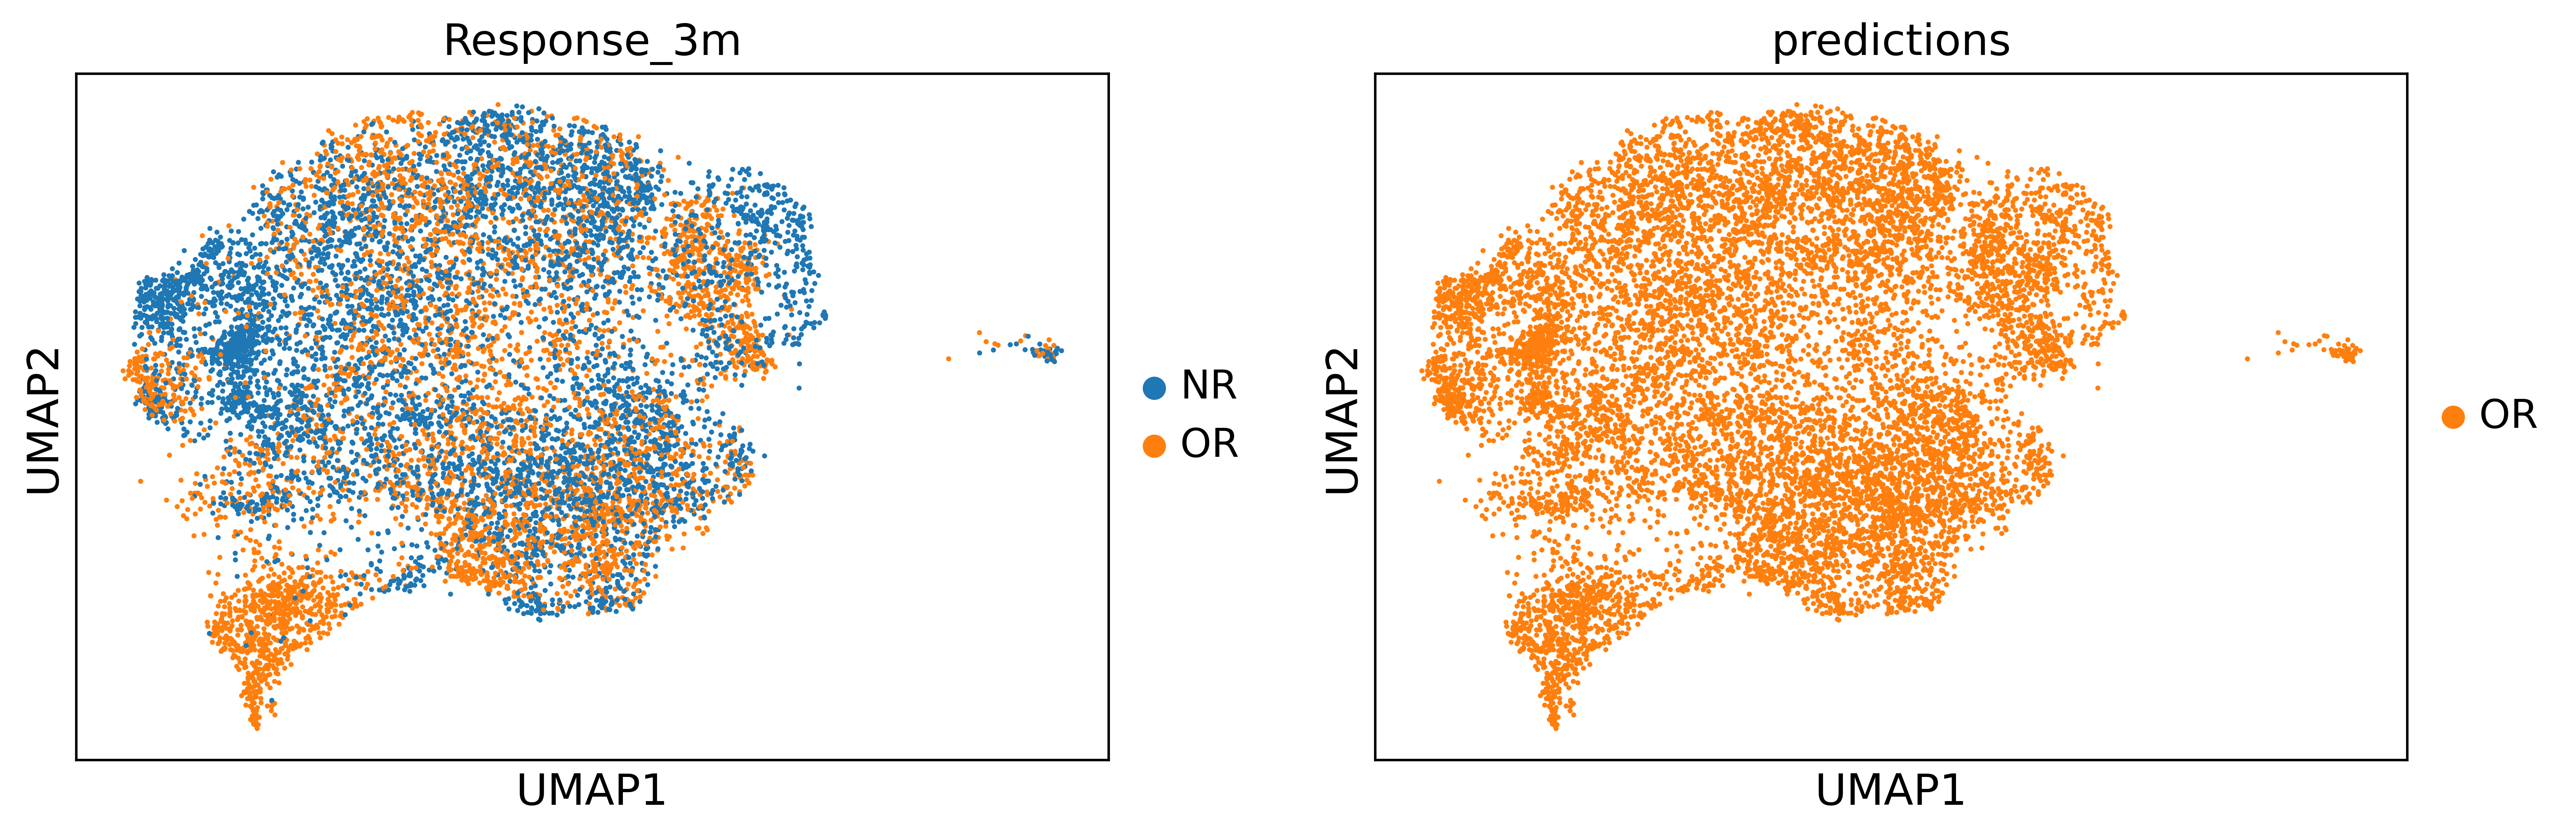

In [ ]:
predictions, labels, results = test(best_model, adata_test)
adata_test_raw.obs["predictions"] = [id2type[p] for p in predictions]

# plot
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] 
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"]
palette_ = {c: palette_[i] for i, c in enumerate(responses)}

with plt.rc_context({"figure.figsize": (6, 4), "figure.dpi": (300)}):
    sc.pl.umap(
        adata_test_raw,
        color=["Response_3m", "predictions"],
        palette=palette_,
        show=False,
    )
    plt.savefig(save_dir / "results.png", dpi=300)

save_dict = {
    "predictions": predictions,
    "labels": labels,
    "results": results,
    "id_maps": id2type
}
with open(save_dir / "results.pkl", "wb") as f:
    pickle.dump(save_dict, f)

results["test/cell_umap"] = wandb.Image(
    str(save_dir / "results.png"),
    caption=f"predictions macro f1 {results['test/macro_f1']:.3f}",
)
wandb.log(results)

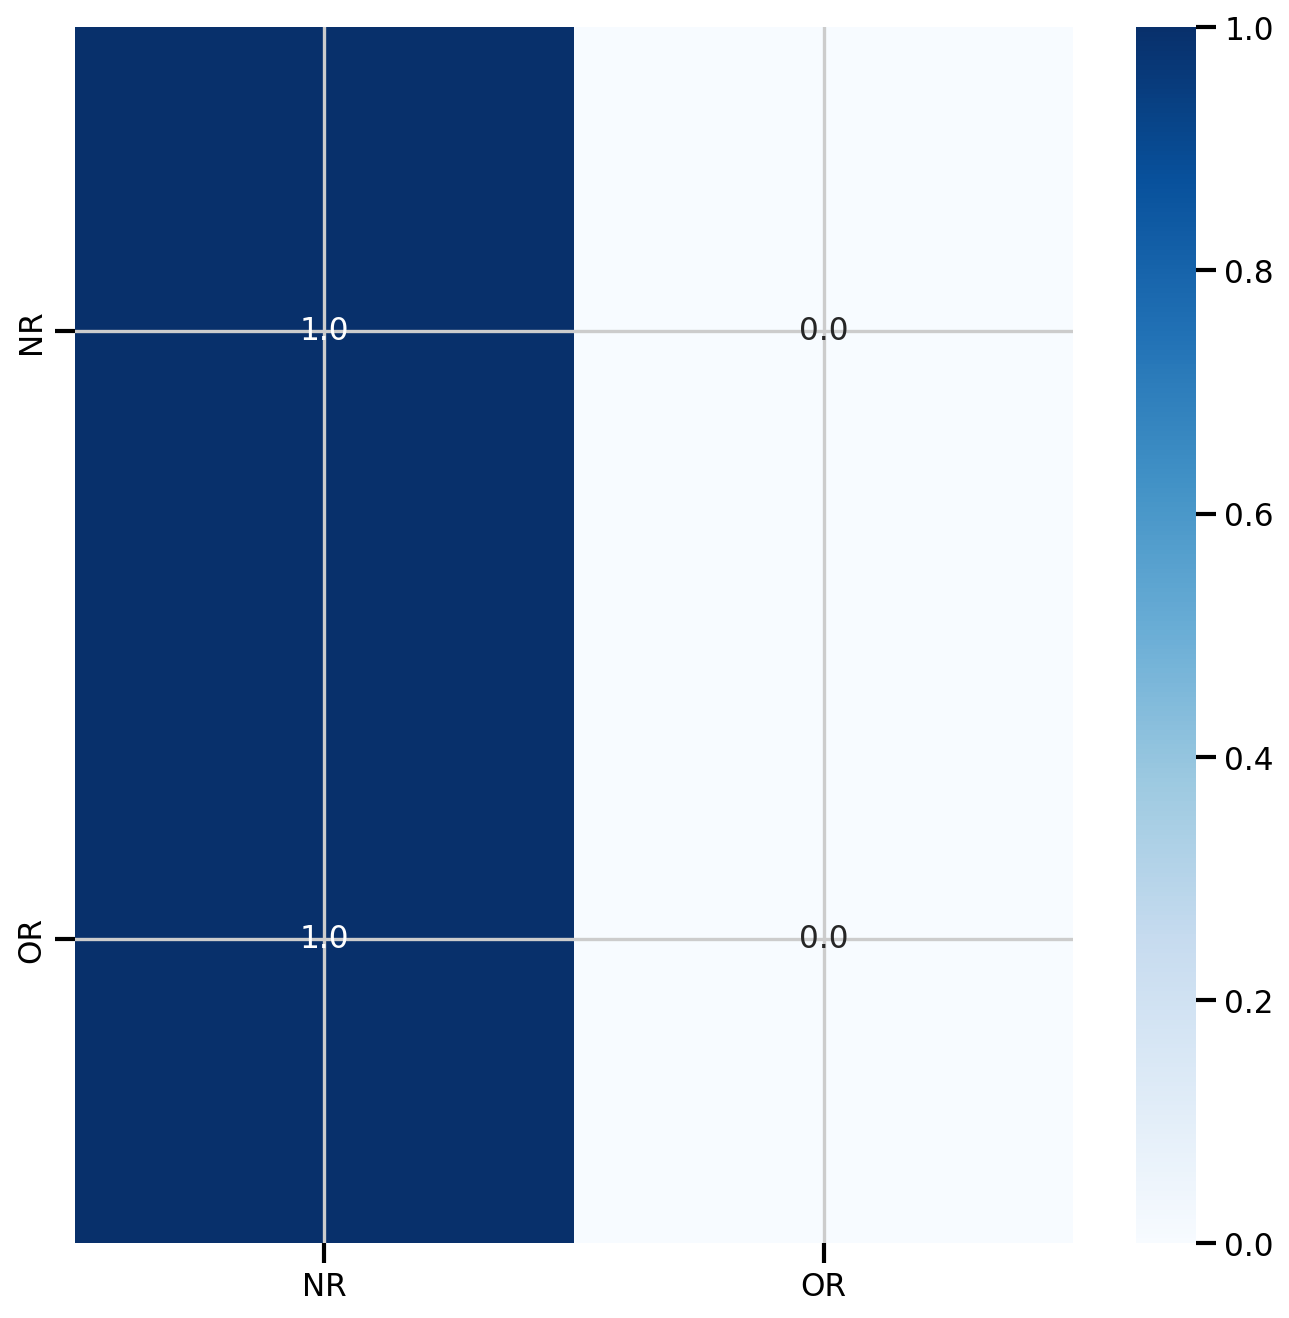

In [ ]:

from sklearn.metrics import confusion_matrix
responses = list(responses)
for i in set([id2type[p] for p in predictions]):
    if i not in responses:
        responses.remove(i)
cm = confusion_matrix(labels, predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=responses[:cm.shape[0]], columns=responses[:cm.shape[1]])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")
plt.savefig(save_dir / "confusion_matrix.png", dpi=300)

results["test/confusion_matrix"] = wandb.Image(
    str(save_dir / "confusion_matrix.png"),
    caption=f"confusion matrix",
)


In [ ]:
# save the model into the save_dir
torch.save(best_model.state_dict(), save_dir / "model.pt")